In [ ]:
### IMOPRTS
%matplotlib inline
from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
plt.style.use('dark_background')

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm 
from torch.utils.data import DataLoader, Dataset
import copy

device = "mps:0"

# Data

In [ ]:
def sample_g(mu, var, n=10_000):
    return torch.randn(n, 2) * var + torch.tensor(mu).view(-1, 2)


class Gaussian2d(Dataset):

    def __init__(self, n: int = 10_000, mu_0=[0, 0], std_0=1):
        self.data = sample_g(torch.tensor(mu_0), std_0, n).reshape(n, 2)

        self.std = self.data.std()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


class MixGaussian2d(Gaussian2d):

    def __init__(self, n: int = 40_000, mu_0=5, std_0=0.5, normalize=False):
        mu_1, mu_2, mu_3, mu_4 = [-mu_0, mu_0], [mu_0,
                                                 -mu_0], [-mu_0,
                                                          -mu_0], [mu_0, mu_0]
        var_1, var_2, var_3, var_4 = std_0, std_0, std_0, std_0
        x_1 = sample_g(mu_1, var_1, n)
        x_2 = sample_g(mu_2, var_2, n)
        x_3 = sample_g(mu_3, var_3, n)
        x_4 = sample_g(mu_4, var_4, n)
        self.data = torch.cat([x_1, x_2, x_3, x_4], dim=0)

        if normalize:
            self.data = (self.data - self.data.mean()) / self.data.std()
        self.std = self.data.std()


d0 = Gaussian2d()
d1 = MixGaussian2d(normalize=False)

plt.figure()
plt.scatter(d0.data[:, 0],
            d0.data[:, 1],
            s=1,
            color="y",
            label="x0 - gaussian noise ")
plt.scatter(d1.data[:, 0], d1.data[:, 1], s=1, label="x1 - data")
plt.legend()
dataloader = DataLoader(d1, batch_size=128, shuffle=True)

## Model

### Network

In [ ]:
class SPE(torch.nn.Module):

    def __init__(self, dim=128, max_positions=10000, scale=20):
        super().__init__()
        self.embedding_size = dim
        self.max_positions = max_positions
        self.scale = scale

    def forward(self, x):
        x = x * self.scale
        freqs = torch.arange(start=0,
                             end=self.embedding_size // 2,
                             dtype=torch.float32,
                             device=x.device)
        w = (1 / self.max_positions)**(2 * freqs / self.embedding_size)
        w = w[None, :]
        x = x[:, None]
        x = torch.cat([torch.sin(w * x), torch.cos(w * x)], dim=-1)
        return x.squeeze(1)


spe = SPE(dim=128, max_positions=10000, scale=100.)

t = torch.linspace(0.001, 1, 100)
#t = 0.25 * t.log()
out = spe(t)
plt.figure()
plt.imshow(out, aspect='auto')

In [ ]:
class MLP(nn.Module):

    def __init__(self, in_dim: int, hid_dim: int, out_dim: int):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hid_dim),
            nn.SiLU(),
            nn.Linear(hid_dim, hid_dim),
            nn.SiLU(),
            nn.Linear(hid_dim, out_dim),
        )

    def forward(self, x):
        return self.mlp(x)


class FiLM(nn.Module):

    def __init__(self, data_dim: int, cond_dim: int):
        super().__init__()
        self.mlp = nn.Sequential(nn.Linear(cond_dim, data_dim), nn.SiLU(),
                                 nn.Linear(data_dim, 2 * data_dim))
        self.act = nn.SiLU()

        self.gn = nn.GroupNorm(num_groups=min(8, data_dim),
                               num_channels=data_dim)

    def forward(self, x, t):
        t = self.mlp(t)

        alpha, beta = torch.chunk(t, chunks=2, dim=-1)

        alpha = alpha / torch.linalg.norm(alpha, dim=-1, keepdim=True)
        beta = beta / torch.linalg.norm(beta, dim=-1, keepdim=True)

        x = alpha * self.gn(x) + beta
        return self.act(x)


class MLP_Block(nn.Module):

    def __init__(self, hid_dim: int, cond_dim: int):
        super().__init__()
        self.mlp = nn.Linear(hid_dim, hid_dim)
        self.film = FiLM(hid_dim, cond_dim)
        self.act = nn.SiLU()

    def forward(self, x, t):
        x = self.film(x, t)
        x = self.mlp(x)
        return self.act(x)


class UNet(nn.Module):

    def __init__(self,
                 in_dim: int,
                 hid_dim: int,
                 n_layers: int,
                 cond_dim: int,
                 spe="home"):
        super().__init__()

        self.cond_dim = cond_dim
        self.spe = SPE(dim=cond_dim, max_positions=10000, scale=100.)


        self.in_mlp = nn.Linear(in_dim, hid_dim)
        self.out_mlp = nn.Linear(hid_dim, in_dim)

        net = nn.ModuleList()
        for i in range(n_layers):
            net.append(MLP_Block(hid_dim, cond_dim))
        self.net = net

    def forward(self, x, t_emb):
        x = self.in_mlp(x)
        for l in self.net:
            x = l(x, t_emb)
        x = self.out_mlp(x)
        return x


model = UNet(in_dim=2, hid_dim=128, cond_dim=32, n_layers=2)
x = torch.tensor([[1.0, 0.0]])
t = torch.ones(1)
t_emb = model.spe(t)
print(t_emb.shape)
print(model(x, t_emb).shape)

### Model

In [20]:
class DiffusionModel(nn.Module):

    def __init__(self, model, sigma_data, device: str = device):
        super().__init__()
        self.model = model
        self.sigma_data = sigma_data
        self.device = device
        self.model.to(device)

        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3)

    def train(self, train_dl, iterations, grad_norm=None, display_step=5000):
        self.model.train()
        it = 0
        pbar = tqdm(range(iterations))
        while it < iterations:
            for x in train_dl:
                x = x.to(self.device)

                loss = self.step(x, it)
                self.optimizer.zero_grad()
                loss.backward()

                if grad_norm is not None:
                    try:
                        torch.nn.utils.clip_grad_norm_(
                            list(self.model.parameters()) +
                            list(self.w_phi.parameters()),
                            max_norm=grad_norm)
                    except:
                        torch.nn.utils.clip_grad_norm_(list(
                            self.model.parameters()),
                                                       max_norm=grad_norm)
                self.optimizer.step()
                pbar.set_postfix({"Loss": loss.item()})
                pbar.update(1)

                if it % display_step == 0:

                    nb_steps = [1, 2, 10, 50]
                    f, ax = plt.subplots(1, len(nb_steps), figsize=(20, 5))

                    x0 = d0.data[:1000]

                    for i, nb_step in enumerate(nb_steps):
                        x1 = self.sample(x0=x0, nb_steps=nb_step)
                        x1 = x1.cpu().detach()
                        ax[i].scatter(x1[:, 0], x1[:, 1])
                    plt.show()
                it += 1

## Rectified Flow

In [35]:
class RectifiedFlow(DiffusionModel):

    def __init__(self, model, sigma_data, device: str = "mps"):
        super().__init__(model, sigma_data, device)

    def step(self, x1, it):

        x0 = torch.randn_like(x1)

        target = x1 - x0
        t = torch.rand(x0.size(0)).to(self.device)

        t = t[:, None]
        interpolant = (1 - t) * x0 + t * x1

        t_emb = self.model.spe(t.view(-1))
        model_output = self.model(interpolant, t_emb)

        loss = ((model_output - target)**2).mean()
        return loss

    @torch.no_grad()
    def sample(self, x0, nb_steps, return_trajectory=False):
        dt = 1 / nb_steps
        t_values = torch.linspace(0, 1, nb_steps + 1)[:-1]

        x = x0.to(device)

        x_out = []
        for t in t_values:
            t = t.reshape(1).to(device)
            t_emb = self.model.spe(t)
            t_emb = t_emb.repeat(x.shape[0], 1)
            x = x + self.model(x, t_emb) * dt

            x_out.append(x.cpu())

        if return_trajectory:
            return x, torch.stack(x_out, dim=-1)
        return x

    @torch.no_grad()
    def reverse_sample(self, x0, nb_steps, return_trajectory=False):
        dt = 1 / nb_steps
        t_values = torch.linspace(1, 0, nb_steps + 1)

        x = x0.to(device)

        x_out = []
        for t in t_values[:-1]:
            t = t.reshape(1).to(device)
            t_emb = self.model.spe(t)
            t_emb = t_emb.repeat(x.shape[0], 1)
            x = x - self.model(x, t_emb) * dt

            x_out.append(x.cpu())

        if return_trajectory:
            return x, torch.stack(x_out, dim=-1)
        return x

    def reflow(self, pairs0, pairs1, iterations, bsize=128):
        self.model.train()
        it = 0
        pbar = tqdm(range(iterations))

        while it < iterations:
            perm = torch.randperm(pairs0.size(0))
            pairs_train0 = pairs0.clone()[perm]
            pairs_train1 = pairs1.clone()[perm]

            for i in range(pairs_train1.shape[0] // bsize):
                x0 = pairs_train0[i * bsize:(i + 1) * bsize].to(self.device)
                x1 = pairs_train1[i * bsize:(i + 1) * bsize].to(self.device)

                target = x1 - x0
                t = torch.rand(x0.size(0)).to(self.device)

                t = t[:, None]
                interpolant = (1 - t) * x0 + t * x1

                t_emb = self.model.spe(t)
                model_output = self.model(interpolant, t_emb)

                loss = ((model_output - target)**2).mean()
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                pbar.set_postfix({"Loss": loss.item()})
                pbar.update(1)
                it += 1

                if it % 2500 == 0:
                    nb_steps = [1, 2, 5, 10]
                    f, ax = plt.subplots(1, len(nb_steps), figsize=(20, 5))

                    x0 = d0.data[:1000]

                    for i, nb_step in enumerate(nb_steps):
                        x1 = self.sample(x0=x0, nb_steps=nb_step)
                        x1 = x1.cpu().detach()
                        ax[i].scatter(x1[:, 0], x1[:, 1])
                    plt.show()

In [ ]:
model = UNet(in_dim=2, hid_dim=512, cond_dim=64, n_layers=4, spe="home")

trainer = RectifiedFlow(model=model, sigma_data=d1.std,
                        device=device).to(device)

trainer.train(dataloader, 1000)

### One sample

In [ ]:
x0 = d0.data
x1 = trainer.sample(x0, 100).cpu()
plt.scatter(x0[:, 0], x0[:, 1], s=1, color="y", label="x0 - prior")
plt.scatter(x1[:, 0], x1[:, 1], s=1, color="r", label="x1 - generated samples")

x0 = d0.data[:3]
x1, x_traj = trainer.sample(x0, 100, return_trajectory=True)

for i in range(x0.shape[0]):
    plt.plot(x_traj[i, 0],
             x_traj[i, 1],
             color="w",
             alpha=1.,
             label="Sampling  " + str(i))

    plt.legend()
plt.show()

### All trajectories

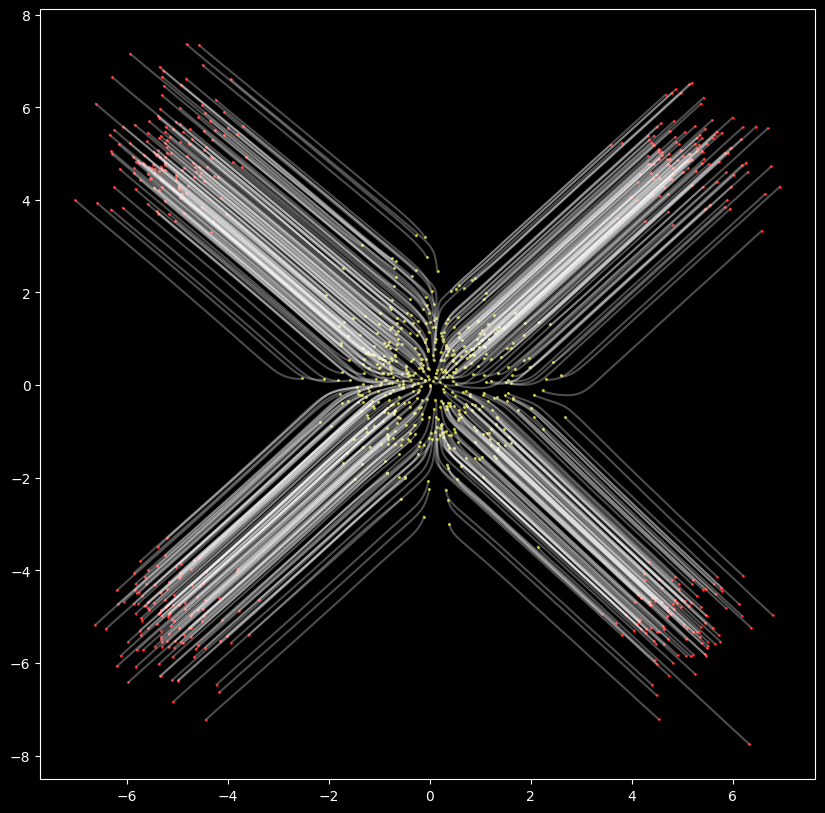

In [26]:
x0 = d0.data[:500]
x1, x_traj = trainer.sample(x0, 100, return_trajectory=True)

x1 = x1.cpu()
plt.figure(figsize=(10, 10))
plt.scatter(x0[:, 0], x0[:, 1], s=1, color="y")
plt.scatter(x1[:, 0], x1[:, 1], s=1, color="r", alpha=1)

for i in range(x0.shape[0]):
    plt.plot(x_traj[i, 0].cpu(), x_traj[i, 1].cpu(), color="w", alpha=0.3)

### Reverse sampling

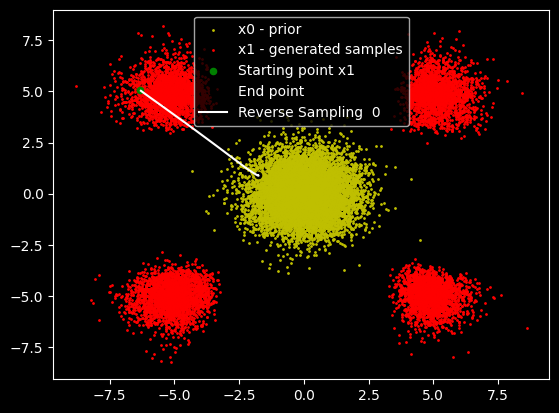

In [32]:
x0 = d0.data
x1 = trainer.sample(x0, 100).cpu()
plt.scatter(x0[:, 0], x0[:, 1], s=1, color="y", label="x0 - prior")
plt.scatter(x1[:, 0], x1[:, 1], s=1, color="r", label="x1 - generated samples")

x0 = d1.data[:1]
x1, x_traj = trainer.reverse_sample(x0, 100, return_trajectory=True)

plt.scatter(x0[:, 0], x0[:, 1], color="g", s=20, label="Starting point x1")
plt.scatter(x1[:, 0].cpu(), x1[:, 1].cpu(), color="k", s=20, label="End point")

for i in range(x0.shape[0]):
    plt.plot(x_traj[i, 0],
             x_traj[i, 1],
             color="w",
             alpha=1.,
             label="Reverse Sampling  " + str(i))

    plt.legend()
plt.show()

In [ ]:
x0 = d0.data
x1 = trainer.sample(x0, 100).cpu()
plt.scatter(x0[:, 0], x0[:, 1], s=1, color="y", label="x0 - prior")
plt.scatter(x1[:, 0], x1[:, 1], s=1, color="r", label="x1 - generated samples")

x1 = d1.data[:1]
x0, x_traj = trainer.reverse_sample(x1, 100, return_trajectory=True)
plt.scatter(x1[:, 0], x1[:, 1], color="g", s=30, label="Starting point x1")

x0 = d0.data[:1]
x_traj = torch.cat([(1 - t) * x1.cpu() + t * x0.cpu()
                    for t in np.linspace(0, 1, 100)], 0)

plt.scatter(x0[:, 0].cpu(),
            x0[:, 1].cpu(),
            color="b",
            s=30,
            label="Randomly selected x0")

for i in range(x0.shape[0]):
    plt.plot(x_traj[:, 0],
             x_traj[:, 1],
             color="w",
             alpha=1.,
             label="Linear interpolation between x0 and x1")

x1, x_traj = trainer.sample(x0, 100, return_trajectory=True)
for i in range(x0.shape[0]):
    plt.plot(x_traj[0, 0],
             x_traj[0, 1],
             color="g",
             alpha=1.,
             label="Sampling from the randomly chose x0")

plt.scatter(x1[:, 0].cpu(),
            x1[:, 1].cpu(),
            color="k",
            s=30,
            label="End point xhat_1")

plt.legend(loc="upper right", fontsize=8)
plt.show()

### Reflow

In [ ]:
x0 = d0.data[:200]
x1, x_traj = trainer.sample(x0, 100, return_trajectory=True)

x1 = x1.cpu()
plt.scatter(x0[:, 0], x0[:, 1], s=1, color="y")
plt.scatter(x1[:, 0], x1[:, 1], s=1, color="r", alpha=1)

for i in range(x0.shape[0]):
    plt.plot(x_traj[i, 0], x_traj[i, 1], color="w", alpha=0.3)

In [ ]:
model2 = copy.deepcopy(model)

trainer2 = RectifiedFlow(model=model2, sigma_data=d1.std,
                         device=device).to(device)

trainer2.reflow(x0, x1, 20000)

In [ ]:
x0 = d0.data[:200]
x1, x_traj = trainer2.sample(x0, 100, return_trajectory=True)

x1 = x1.cpu()
plt.scatter(x0[:, 0], x0[:, 1], s=1, color="y")
plt.scatter(x1[:, 0], x1[:, 1], s=1, color="r", alpha=1)

for i in range(x0.shape[0]):
    plt.plot(x_traj[i, 0], x_traj[i, 1], color="w", alpha=0.3)

## Straight Flow Matching

In [39]:
class StraightFlow(DiffusionModel):

    def __init__(self, model, sigma_data, device: str = "mps", sigma_min = 0.001):
        super().__init__(model, sigma_data, device)
        self.sigma_min = sigma_min

    def step(self, x1, it):

        x0 = torch.randn_like(x1)

        
        t = torch.rand(x0.size(0)).to(self.device)
        
        target = (x1 - x0*(1-self.sigma_min))

        t = t[:, None]
        interpolant = (1 - (1-self.sigma_min)*t) * x0 + t * x1

        t_emb = self.model.spe(t.view(-1))
        model_output = self.model(interpolant, t_emb)

        loss = ((model_output - target)**2).mean()
        return loss

    @torch.no_grad()
    def sample(self, x0, nb_steps, return_trajectory=False):
        dt = 1 / nb_steps
        t_values = torch.linspace(0, 1, nb_steps+1)[:-1]

        x = x0.to(device)

        x_out = []
        for t in t_values:
            t = t.reshape(1).to(device)
            t_emb = self.model.spe(t)
            t_emb = t_emb.repeat(x.shape[0], 1)
            x = x + self.model(x, t_emb) * dt

            x_out.append(x.cpu())

        if return_trajectory:
            return x, torch.stack(x_out, dim=-1)
        return x

    @torch.no_grad()
    def reverse_sample(self, x0, nb_steps, return_trajectory=False):
        dt = 1 / nb_steps
        t_values = torch.linspace(1, 0, nb_steps + 1)

        x = x0.to(device)

        x_out = []
        for t in t_values[:-1]:
            t = t.reshape(1).to(device)
            t_emb = self.model.spe(t)
            t_emb = t_emb.repeat(x.shape[0], 1)
            x = x - self.model(x, t_emb) * dt

            x_out.append(x.cpu())

        if return_trajectory:
            return x, torch.stack(x_out, dim=-1)
        return x

    def reflow(self, pairs0, pairs1, iterations, bsize=128):
        self.model.train()
        it = 0
        pbar = tqdm(range(iterations))

        while it < iterations:
            perm = torch.randperm(pairs0.size(0))
            pairs_train0 = pairs0.clone()[perm]
            pairs_train1 = pairs1.clone()[perm]

            for i in range(pairs_train1.shape[0] // bsize):
                x0 = pairs_train0[i * bsize:(i + 1) * bsize].to(self.device)
                x1 = pairs_train1[i * bsize:(i + 1) * bsize].to(self.device)

                target = x1 - x0
                t = torch.rand(x0.size(0)).to(self.device)

                t = t[:, None]
                interpolant = (1 - t) * x0 + t * x1

                t_emb = self.model.spe(t)
                model_output = self.model(interpolant, t_emb)

                loss = ((model_output - target)**2).mean()
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                pbar.set_postfix({"Loss": loss.item()})
                pbar.update(1)
                it += 1

                if it % 2500 == 0:
                    nb_steps = [1, 2, 5, 10]
                    f, ax = plt.subplots(1, len(nb_steps), figsize=(20, 5))

                    x0 = d0.data[:1000]

                    for i, nb_step in enumerate(nb_steps):
                        x1 = self.sample(x0=x0, nb_steps=nb_step)
                        x1 = x1.cpu().detach()
                        ax[i].scatter(x1[:, 0], x1[:, 1])
                    plt.show()



  0%|          | 4/1000 [00:52<3:38:38, 13.17s/it, Loss=26.7]


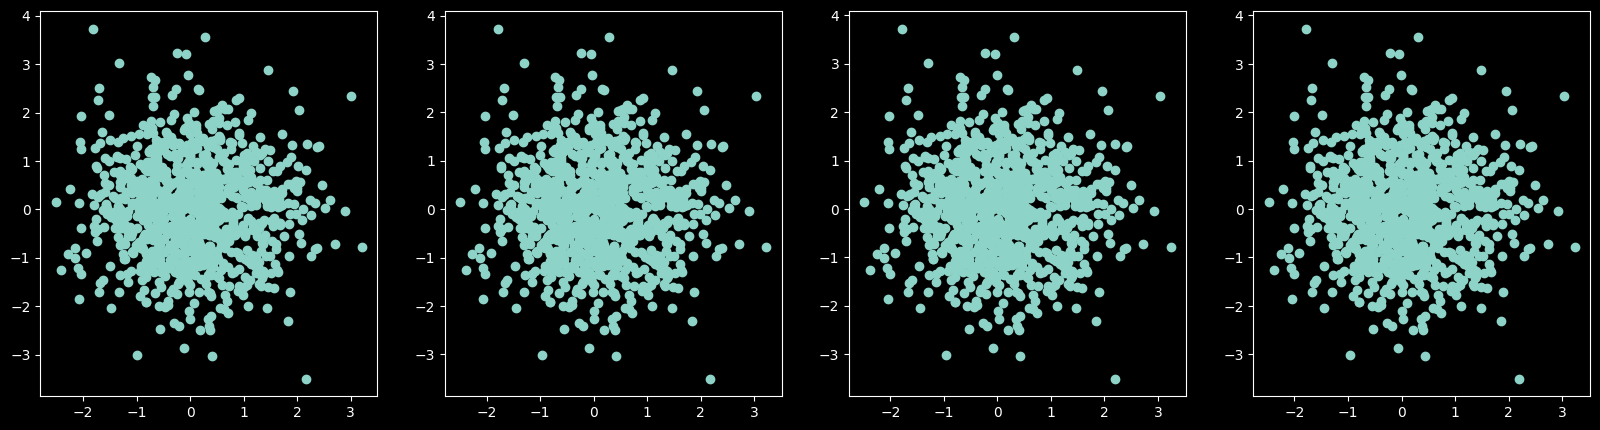

KeyboardInterrupt: 

In [40]:
model = UNet(in_dim=2, hid_dim=512, cond_dim=64, n_layers=4, spe="home")

trainer = StraightFlow(model=model, sigma_data=d1.std,
                        device=device).to(device)

trainer.train(dataloader, 1000)

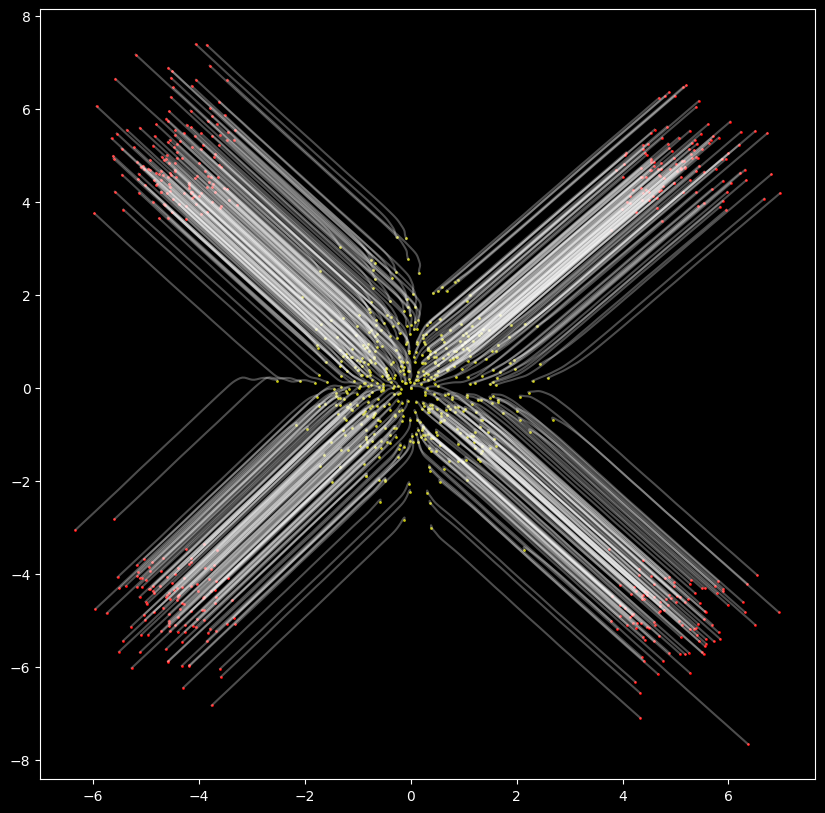

In [41]:
x0 = d0.data[:500]
x1, x_traj = trainer.sample(x0, 100, return_trajectory=True)

x1 = x1.cpu()
plt.figure(figsize=(10, 10))
plt.scatter(x0[:, 0], x0[:, 1], s=1, color="y")
plt.scatter(x1[:, 0], x1[:, 1], s=1, color="r", alpha=1)

for i in range(x0.shape[0]):
    plt.plot(x_traj[i, 0].cpu(), x_traj[i, 1].cpu(), color="w", alpha=0.3)

## TrigFlow

In [25]:
class TrigFlow(DiffusionModel):

    def __init__(self, model, sigma_data, device=device):
        super().__init__(model, sigma_data, device)
        self.p_mean, self.p_std = -1.2, 1.2

    def step(self, x, it):
        b, dim = x.shape
        tau = torch.randn(b, 1, device=self.device) * self.p_std + self.p_mean
        t = torch.arctan(torch.exp(tau) / self.sigma_data)

        z = torch.randn_like(x) * self.sigma_data
        x_t = torch.cos(t) * x + torch.sin(t) * z
        dx_dt = t.cos() * z - t.sin() * x
        t_emb = self.model.spe(t.squeeze(1))

        f = self.model(x_t / self.sigma_data, t_emb)

        loss = ((self.sigma_data * f - dx_dt)**2)
        return loss.mean()

    @torch.no_grad()
    def sample(self, x0, nb_steps=50, return_trajectory=False):
        xout = []

        xn = x0 * self.sigma_data
        xn = xn.to(device)

        # Linear sampling
        t = torch.linspace(np.pi / 2, 0, nb_steps + 1)

        for i, tc in enumerate(t[:-1]):
            tc = tc.view(-1).to(self.device)
            tc_next = t[i + 1].view(-1).to(self.device)

            tc_emb = self.model.spe(tc).repeat(xn.shape[0], 1)

            delta_t = tc_next - tc

            xn = xn * torch.cos(delta_t) + self.sigma_data * torch.sin(
                delta_t) * self.model(xn / self.sigma_data, tc_emb)

            xout.append(xn.clone().cpu())

        if return_trajectory:
            return xn, torch.stack(xout, dim=-1)
        return xn


In [ ]:
model = UNet(in_dim=2, hid_dim=512, cond_dim=32, n_layers=2, spe="home")

trainer = TrigFlow(model=model, sigma_data=d1.std, device=device).to(device)

trainer.train(dataloader, 20000, display_step=5000)

In [ ]:
x0 = d0.data
x1 = trainer.sample(x0, 100).cpu()
plt.scatter(x0[:, 0], x0[:, 1], s=1, color="y")
plt.scatter(x1[:, 0], x1[:, 1], s=1, color="r")
plt.scatter(d1.data[:, 0], d1.data[:, 1], s=1, alpha=0.05)

plt.show()

In [ ]:
x0 = d0.data[:500]
x1, x_traj = trainer.sample(x0, 100, return_trajectory=True)

x1 = x1.cpu()
plt.figure(figsize=(10, 10))
plt.scatter(x0[:, 0], x0[:, 1], s=1, color="y")
plt.scatter(x1[:, 0], x1[:, 1], s=1, color="r", alpha=1)

for i in range(x0.shape[0]):
    plt.plot(x_traj[i, 0].cpu(), x_traj[i, 1].cpu(), color="w", alpha=0.3)

## EDM

In [34]:
class EDM(DiffusionModel):

    def __init__(self, model, sigma_data, device=device):
        super().__init__(model, sigma_data, device)
        self.p_mean, self.p_std = -1.2, 1.2

        self.sd = sigma_data

    def _get_weight(self, sigma: torch.Tensor) -> torch.Tensor:
        return (sigma**2 + self.sd**2) / (sigma * self.sd)**2

    def _get_scalings(self, sigma: torch.Tensor):
        c_skip = self.sd**2 / (sigma**2 + self.sd**2)
        c_out = sigma * self.sd / (sigma**2 + self.sd**2).sqrt()
        c_in = 1 / (self.sd**2 + sigma**2).sqrt()
        c_noise = 0.25 * sigma.log()

        return c_skip, c_out, c_in, c_noise

    def model_forward(self, x, sigma):

        c_skip, c_out, c_in, c_noise = self._get_scalings(sigma)

        t_emb = self.model.spe(c_noise)

        f_xy = self.model(c_in[:, None] * x, t_emb)

        d = c_skip[:, None] * x + c_out[:, None] * f_xy
        return d

    def step(self, x: torch.Tensor, it) -> torch.Tensor:
        b, *_ = x.shape

        z = torch.randn(b, 1, device=self.device)
        sigma = (z * self.p_std + self.p_mean).exp()

        x_noisy = x + torch.randn_like(x) * sigma

        #d = self.model(x=x_noisy, t_emb=self.model.spe(sigma.squeeze()))

        d = self.model_forward(x_noisy, sigma.view(-1))
        weight = self._get_weight(sigma)

        loss = weight * ((d - x)**2)
        loss = loss.mean()

        return loss

    def get_steps(self, n_steps, rho, sigma_min, sigma_max):
        step_indices = torch.arange(0, n_steps)
        t_steps = (sigma_min**(1 / rho) + step_indices / (n_steps - 1) *
                   (sigma_max**(1 / rho) - sigma_min**(1 / rho)))**rho
        t_steps = torch.cat([torch.tensor([0.]), t_steps])
        t_steps = torch.as_tensor(t_steps)

        return t_steps

    @torch.no_grad()
    def sample(self,
               x0,
               nb_steps=100,
               sigma_max=20,
               sigma_min=0.01,
               rho=7,
               return_trajectory=False):
        out_samples = []

        # Sample initial noise
        samples = x0.to(self.device) * sigma_max

        # sample steps
        t_steps = self.get_steps(nb_steps, rho, sigma_min,
                                 sigma_max).to(self.device)

        # Perform the sampling
        for i in range(nb_steps - 1):
            sigma_t = t_steps[nb_steps - i - 1]
            sigma_t_next = t_steps[nb_steps - i - 2]

            model_output = self.model_forward(
                samples,
                sigma_t.view(-1).repeat(x0.shape[0]))

            samples = samples + (samples - model_output) / sigma_t * (
                sigma_t_next - sigma_t)

            out_samples.append(samples)

        if return_trajectory:
            return samples, torch.stack(out_samples, dim=-1)

        return samples


In [ ]:
model = UNet(in_dim=2, hid_dim=512, cond_dim=64, n_layers=2, spe="home")

trainer = EDM(model=model, sigma_data=d1.std, device=device).to(device)

trainer.train(dataloader, 20000)


In [ ]:
x0 = d0.data
x1 = trainer.sample(x0, 100, sigma_min=0.001, sigma_max=20).cpu()
plt.scatter(x0[:, 0], x0[:, 1], s=1, color="y")
plt.scatter(x1[:, 0], x1[:, 1], s=1, color="r")
plt.show()

In [ ]:
x0 = d0.data[:500]
x1, x_traj = trainer.sample(x0, 100, return_trajectory=True, sigma_max=5)

x1 = x1.cpu()
plt.figure(figsize=(20, 20))
plt.scatter(x0[:, 0], x0[:, 1], s=1, color="y")
plt.scatter(x1[:, 0], x1[:, 1], s=1, color="r", alpha=1)

for i in range(x0.shape[0]):
    plt.plot(x_traj[i, 0].cpu(), x_traj[i, 1].cpu(), color="w", alpha=0.3)

## SS_consistency

In [7]:
class SSM(DiffusionModel):

    def __init__(self, model, sigma_data, device=device):
        super().__init__(model, sigma_data, device)
        self.p_mean, self.p_std = -1., 1.4
        self.w_phi = nn.Linear(self.model.cond_dim, 1)
        self.optimizer = torch.optim.AdamW(list(self.model.parameters()) +
                                           list(self.w_phi.parameters()),
                                           lr=1e-4)
        self.warmup = 1000
        self.c = .1

    def step(self, x, it):
        b, dim = x.shape
        sigma = torch.randn(b, 1,
                            device=self.device) * self.p_std + self.p_mean

        sigma = sigma.exp()
        t = torch.arctan(sigma / self.sigma_data)

        # Get z and x_t
        z = torch.randn_like(x) * self.sigma_data
        x_t = torch.cos(t) * x + torch.sin(t) * z

        # consistency trainin
        dx_dt = t.cos() * z - t.sin() * x

        # Compute model
        t_emb = self.model.spe(t.view(-1))
        #f = self.model(x_t / self.sigma_data, t_emb)

        # Compute JVP
        fn = lambda x_t, tc: self.model(x_t, self.model.spe(tc.view(-1)))

        #_, jvp = torch.autograd.functional.jvp(fn, (x_t, t), (dx_dt, torch.ones(b, 1).to(x_t)))

        v_x = torch.cos(t) * torch.sin(t) * dx_dt / self.sigma_data
        v_t = torch.cos(t) * torch.sin(t)
        f_theta, f_theta_grad = torch.func.jvp(fn, (x_t / self.sigma_data, t),
                                               (v_x, v_t))

        f_theta_minus = f_theta.clone().detach()
        f_theta_grad = f_theta_grad.detach()

        r = min(1., it / self.warmup)
        g = -torch.cos(t) * torch.cos(t) * (self.sigma_data * f_theta_minus -
                                            dx_dt)
        second_term = -r * (torch.cos(t) * torch.sin(t) * x_t +
                            self.sigma_data * f_theta_grad)
        g = g + second_term

        #g = -t.cos()**2 * (self.sigma_data * f.detach() - dx_dt) - r * t.cos() * t.sin() * x_t - r * t.cos() * t.sin() * self.sigma_data * jvp
        #_, jvp = torch.autograd.functional.jvp(fn, (x_t, t), (t.cos() * t.sin() * dx_dt.detach(), t.cos() * t.sin() * self.sd))
        #g = -t.cos() ** 2 * (self.sd * f.detach() - dx_dt) - r * t.cos() * t.sin() * x_t   -  r * self.sd * jvp

        #g = g / (g.norm(p=2, dim=1)[:, None] + self.c)

        # G NORMALIZATION
        g_norm = torch.linalg.vector_norm(g, dim=(1), keepdim=True)
        g_norm = g_norm * np.sqrt(g_norm.numel() / g.numel())
        g = g / (g_norm + self.c)

        #g = torch.clamp(g, -1., 1.)

        # WEIGHTING
        weight = 1 / sigma
        w = self.w_phi(t_emb)
        loss = (f_theta - f_theta_minus - g)**2

        loss = loss * weight * (1 / w.exp()) + w
        return loss.mean()

    @torch.no_grad()
    def sample(self, x0, nb_steps=50, return_trajectory=False):
        xout = []

        xn = x0 * self.sigma_data
        xn = xn.to(device)

        # Linear sampling
        t = torch.linspace(np.pi / 2, 0, nb_steps + 1)

        for i, tc in enumerate(t[:-1]):
            tc = tc.view(-1).to(self.device)
            tc_next = t[i + 1].view(-1).to(self.device)

            tc_emb = self.model.spe(tc).repeat(xn.shape[0], 1)

            delta_t = tc_next - tc

            xn = xn * torch.cos(delta_t) + self.sigma_data * torch.sin(
                delta_t) * self.model(xn / self.sigma_data, tc_emb)

            xout.append(xn.clone().cpu())

        if return_trajectory:
            return xn, torch.stack(xout, dim=-1)
        return xn

    @torch.no_grad()
    def one_step_sample(self, x0):
        xn = x0 * self.sigma_data
        xn = xn.to(device)

        # Linear sampling
        t = torch.tensor([np.pi / 2]).to(device)
        t_emb = self.model.spe(t).repeat(xn.shape[0], 1)
        pred_x0 = torch.cos(t) * xn - torch.sin(t) * self.sigma_data * model(
            xn / self.sigma_data, t_emb)
        return pred_x0.cpu()


In [ ]:
d0 = Gaussian2d()
d1 = MixGaussian2d(normalize=True)

plt.figure()
plt.scatter(d0.data[:, 0], d0.data[:, 1], s=1, color="y")
plt.scatter(d1.data[:, 0], d1.data[:, 1], s=1)
print(d1.std)

dataloader = DataLoader(d1, batch_size=128, shuffle=True)

model = UNet(in_dim=2, hid_dim=512, cond_dim=64, n_layers=2, spe="scm")

trainer = SSM(model=model, sigma_data=d1.std, device=device).to(device)

trainer.train(dataloader, 20000, display_step=5000, grad_norm=100.)

In [ ]:
trainer = SSM(model=model, sigma_data=d1.std, device=device).to(device)

x0 = d0.data
x1 = trainer.sample(x0, 1).cpu()
plt.scatter(x0[:, 0], x0[:, 1], s=1, color="y")
plt.scatter(x1[:, 0], x1[:, 1], s=1, color="r")
plt.show()

In [ ]:
x0 = d0.data[:500]
x1, x_traj = trainer.sample(x0, 2, return_trajectory=True)

x1 = x1.cpu()
plt.figure(figsize=(20, 20))
plt.scatter(x0[:, 0], x0[:, 1], s=1, color="y")
plt.scatter(x1[:, 0], x1[:, 1], s=1, color="r", alpha=1)

for i in range(x0.shape[0]):
    plt.plot(x_traj[i, 0].cpu(), x_traj[i, 1].cpu(), color="w", alpha=0.3)

## Old

In [41]:
from tqdm.auto import tqdm


class CM(nn.Module):

    def __init__(self, model, sigma_data, device: str = "mps"):
        super().__init__()
        self.model = model
        self.sd = sigma_data
        self.device = device
        self.model.to(self.device)
        self.w_phi = nn.Linear(self.model.cond_dim, 1)
        self.optimizer = torch.optim.AdamW(list(self.model.parameters()) +
                                           list(self.w_phi.parameters()),
                                           lr=5e-4)
        self.warmup = 2000
        self.c = .1
        self.p_mean, self.p_std = -1.2, 1.2

    def step(self, x, it):
        b, dim = x.shape
        tau = torch.randn(b, 1, device=self.device) * self.p_std + self.p_mean
        t = torch.arctan(torch.exp(tau) / self.sd)
        z = torch.randn_like(x) * self.sd
        x_t = torch.cos(t) * x + torch.sin(t) * z
        dx_dt = t.cos() * z - t.sin() * x
        r = min(1, it / self.warmup)
        t_emb = self.model.spe(t.squeeze(1))
        f = self.model(x_t / self.sd, t_emb)

        # Compute JVP
        fn = lambda x_t, tc: self.model(x_t / self.sd,
                                        self.model.spe(tc.squeeze()))
        _, jvp = torch.autograd.functional.jvp(
            fn, (x_t, t), (dx_dt, torch.ones(b, 1).to(x_t)))
        g = -t.cos()**2 * (self.sd * f.detach() - dx_dt) - r * t.cos() * t.sin(
        ) * x_t - r * t.cos() * t.sin() * self.sd * jvp
        #_, jvp = torch.autograd.functional.jvp(fn, (x_t, t), (t.cos() * t.sin() * dx_dt.detach(), t.cos() * t.sin() * self.sd))
        #g = -t.cos() ** 2 * (self.sd * f.detach() - dx_dt) - r * t.cos() * t.sin() * x_t   -  r * self.sd * jvp

        g = g / (g.norm(p=2, dim=1)[:, None] + self.c)
        g = g.detach()

        w = self.w_phi(t_emb)
        loss = (w.exp() / dim) * ((f - f.detach() - g)**2) - w  ## FIX

        return loss.mean()

    def train(self, train_dl, iterations):
        self.model.train()
        it = 0
        pbar = tqdm(range(iterations))
        while it < iterations:
            for x in train_dl:
                x = x.to(self.device)

                loss = self.step(x, it)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                pbar.set_postfix({"Loss": loss.item()})
                pbar.update(1)
                it += 1

                if it % 1000 == 0:
                    print("2 steps")
                    g = self.multi_sample(nb_steps=2)
                    g = g.cpu().detach()
                    f, ax = plt.subplots(1, 2, figsize=(12, 5))

                    ax[0].scatter(g[:, 0], g[:, 1])

                    times = torch.linspace(0, np.pi / 2, 100).to(self.device)
                    times_emb = self.model.spe(times)
                    times_weight = self.w_phi(times_emb).detach().cpu().numpy()
                    ax[1].plot(times.cpu(), times_weight.squeeze())
                    plt.show()

                    print("10 steps")
                    g = self.multi_sample(nb_steps=10)
                    g = g.cpu().detach()
                    f, ax = plt.subplots(1, 2, figsize=(12, 5))

                    ax[0].scatter(g[:, 0], g[:, 1])

                    times = torch.linspace(0, np.pi / 2, 100).to(self.device)
                    times_emb = self.model.spe(times)
                    times_weight = self.w_phi(times_emb).detach().cpu().numpy()
                    ax[1].plot(times.cpu(), times_weight.squeeze())
                    plt.show()

    @torch.no_grad()
    def sample(self):
        t = torch.arctan(10 / self.sd).view(-1).repeat(5000).to(self.device)

        t = torch.tensor(np.pi / 2).reshape(-1).repeat(5000).to(self.device)
        xn = torch.randn((5000, 2), device=self.device)

        xn = -self.sd * self.model(xn / self.sd, self.model.spe(t))

        return xn

        return xn, -self.sd * self.model(xn / self.sd, self.model.spe(t)).cpu()

    @torch.no_grad()
    def multi_sample(self, nb_steps=2, n_samples=10000):
        xn = torch.randn((n_samples, 2), device=self.device) * self.sd
        t = torch.linspace(np.pi / 2, 0, nb_steps)

        delta_t = (t[1] - t[0]).to(self.device)

        for tc in t[:-1]:
            tc = tc.view(-1).repeat(n_samples).to(self.device)
            xn = xn * torch.cos(-delta_t) - self.sd * torch.sin(
                -delta_t) * self.model(xn / self.sd, self.model.spe(tc))
            #xn = xn + delta_t * self.model(xn/self.sd, self.model.spe(tc))

        return xn


class TrigFlow(CM):

    def __init__(self, model, sigma_data, device="mps"):
        super().__init__(model, sigma_data, device)
        self.model = model
        self.sd = sigma_data
        self.device = device
        self.model.to(self.device)
        self.optimizer = torch.optim.AdamW(list(self.model.parameters()))
        self.p_mean, self.p_std = -1.2, 1.2

    def step(self, x, it):
        b, dim = x.shape
        tau = torch.randn(b, 1, device=self.device) * self.p_std + self.p_mean
        t = torch.arctan(torch.exp(tau) / self.sd)

        #t = torch.rand((b, 1),device=self.device)*np.pi/2
        z = torch.randn_like(x) * self.sd
        x_t = torch.cos(t) * x + torch.sin(t) * z
        dx_dt = t.cos() * z - t.sin() * x
        t_emb = self.model.spe(t.squeeze(1))
        f = self.model(x_t / self.sd, t_emb)

        loss = ((self.sd * f - dx_dt)**2)
        return loss.mean()

    def train(self, train_dl, iterations):
        self.model.train()
        it = 0
        pbar = tqdm(range(iterations))
        while it < iterations:
            for x in train_dl:
                x = x.to(self.device)

                loss = self.step(x, it)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                it += 1
                pbar.update(1)

                if it % 200 == 0:
                    pbar.set_postfix({"Loss": loss.item()})

                if it % 200 == 0:
                    xn = self.sample()
                    xn = xn.cpu().detach()
                    f, ax = plt.subplots(1, 2, figsize=(12, 5))
                    ax[0].scatter(xn[:, 0], xn[:, 1])
                    plt.show()

    @torch.no_grad()
    def sample(self, nb_steps=40, n_samples=5000):
        xn = torch.randn((n_samples, 2), device=self.device) * self.sd
        t = torch.linspace(np.pi / 2, 0, nb_steps)

        delta_t = (t[1] - t[0]).to(self.device)

        for tc in t[:-1]:
            tc = tc.view(-1).repeat(5000).to(self.device)
            xn = xn * torch.cos(-delta_t) - self.sd * torch.sin(
                -delta_t) * self.model(xn / self.sd, self.model.spe(tc))
            #xn = xn + delta_t * self.model(xn/self.sd, self.model.spe(tc))

        return xn
